# Organize data into stratified folds

We have 29 sequences with n frames ranging from 6 all the way up to 26. To enable later crossfold validation, I'd like to spread these samples across 6 different groups. That way I can use 3 groups for training, 2 for validation, and 1 for hold out. Any augmented images generated later will stay with their source group.

In [1]:
import sys

sys.path.append('../src')

import snek_utils as snu
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from random import shuffle

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
dat = pd.read_csv('../data/CVC-ClinicDB-dataset.csv', index_col=0)

dat.info()
dat.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      612 non-null    object
 1   frame_number  612 non-null    int64 
 2   sequence      612 non-null    int64 
 3   img_filepath  612 non-null    object
 4   gt_filepath   612 non-null    object
dtypes: int64(2), object(3)
memory usage: 28.7+ KB


,filename,frame_number,sequence,img_filepath,gt_filepath
0,1.tif,1,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...
1,2.tif,2,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...
2,3.tif,3,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...


## Sequence distribution

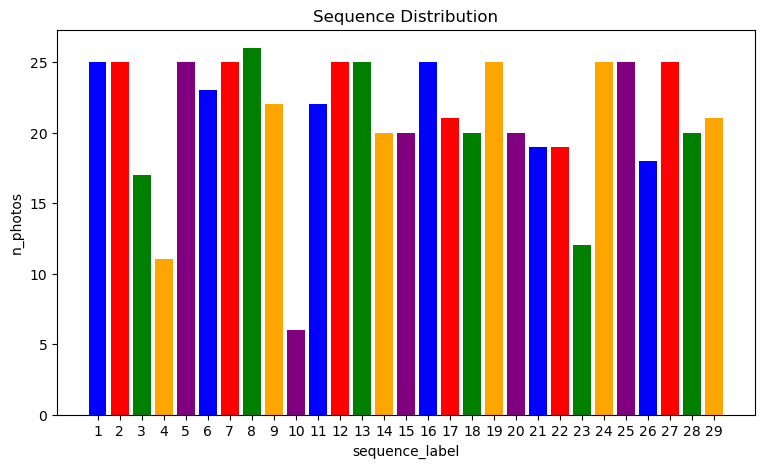

In [3]:
seq = dat['sequence'].value_counts()
seq = seq.sort_index()

bar_colors = (['blue','red','green','orange','purple'] * 5) + ['blue','red','green','orange']

plt.figure(figsize=(9,5))
plt.title('Sequence Distribution')
plt.bar(seq.index, seq.values, tick_label=seq.index, color=bar_colors)
plt.xlabel('sequence_label')
plt.ylabel('n_photos')
plt.show()

In [4]:
# Instinctively I know there's a neater way to do this,
# but don't let the perfect be the enemy of the good. Weigh
# the time it would take to come up with a better sequence
# against what I need right now.

# Initialize column
dat['crossfold_group'] = 0

# I want this many stratified groups
n_groups = 6

for seq in set(dat['sequence']):
    tmp = dat[dat['sequence'] == seq]

    # Just take the indexes and just... shuffle
    # it a bunch.
    tmp_index = list(tmp.index)
    
    for i in range(100):
        shuffle(tmp_index)

    # Sequentially split it into 6
    # different groups.
    sets = snu.split(tmp_index, n_groups)

    # Assign the crossfold group number
    # using the index values
    for i, idx_set in enumerate(sets):
        for row_idx in idx_set:
            dat.at[row_idx, 'crossfold_group'] = i + 1

dat['crossfold_group'].value_counts()    

crossfold_group
1    119
2    106
3    100
4     98
5     96
6     93
Name: count, dtype: int64

This isn't perfect, but I'm more concerned with even sequence representation than equal folds- they're close enough for me.

In [5]:
dat.to_csv('../data/stratified-dataset.csv')